# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Walter Thornton and Dwayne Kennemore

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [80]:
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

%matplotlib inline
pd.set_option('display.max_rows', 500)

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [81]:
# open the files
train_data = pd.read_csv('train_data_hw4.csv', sep=",", header=0)
test_data = pd.read_csv('test_data_hw4.csv', sep=",", header=0)

In [82]:
y_train = train_data['rentals'].values
X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values

y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values
train_data = train_data.drop('Unnamed: 0', 1)
train_data = train_data.drop('Unnamed: 0.1', 1)


In [83]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

(331, 28) (331, 1) (400, 28) (400, 1)


In [84]:
test_data.head(5)

,Unnamed: 0,Unnamed: 0.1,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
0,0,0,0.0,1.0,-1.341801,-1.363792,-0.500703,0.040945,3830.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0.0,1.0,-1.431146,-1.665877,0.132958,2.036025,2114.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,2,2,0.0,1.0,1.695943,1.757749,-0.457103,-0.523392,915.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,3,3,0.0,1.0,-0.805728,-0.759623,-0.997746,0.986696,4322.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,4,0.0,0.0,0.981180,0.952190,0.441062,0.311061,6591.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:


*Analysis*


Only thee lasso regression had values close to 0. These seven are indicated below in the list of Lasso coefficients. 
The ridge regression yielded no such results. Some of these coincide with the predictors from hw3 that were deemed unnecessary. Monthe 2, month 5, holiday, month 8, month 12, day_of_week_4 and weather 2 all recieved 0's on the lasso regression. This makes sense, since these predictors convey similar information as seasons, weather etc.
Ridge regression seems to give atemp and temp the same coeff, with opposong signs, suggesting that they almost 'cancel each other out'. Lasso gives a larger negative weight to atemp.
Since lasso 0's out a number of of predictors and simplifies the model. Both reduce coefficients, but lasso makes the model itself less complex.

In [85]:
alpha_values = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
ridge_models = {}
lasso_models = {}

for alpha_val in alpha_values:

    # build the ridge and lasso regression model with specified lambda, ie, alpha
    ridge_reg = Ridge(alpha = alpha_val)
    lasso_reg = Lasso(alpha = alpha_val)

    # cross validate
    scores_r = cross_val_score(ridge_reg, X_train, y_train, cv=10)
    score_r = np.mean(scores_r)
    temp_dict_r = {alpha_val : score_r}
    ridge_models.update(temp_dict_r)
    
    scores_l = cross_val_score(lasso_reg, X_train, y_train, cv=10)
    score_l = np.mean(scores_l)
    temp_dict_l = {alpha_val : score_l}
    lasso_models.update(temp_dict_l)



best_lasso_alpha = max(lasso_models, key=lasso_models.get)
best_lasso_score =lasso_models.get(best_lasso_alpha)

best_ridge_alpha = max(ridge_models, key=ridge_models.get)
best_ridge_score =ridge_models.get(best_ridge_alpha)

print('The best ridge model has alpha=', best_ridge_alpha)
print('The best ridge model has score=', best_ridge_score)

print('The best lasso model has alpha=', best_lasso_alpha)
print('The best lasso model has score=', best_lasso_score)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The best ridge model has alpha= 10
The best ridge model has score= 0.436358716542
The best lasso model has alpha= 10
The best lasso model has score= 0.415939790448


In [86]:
# fit best validated Ridge and lasso models

ridge_reg = Ridge(alpha = best_ridge_alpha)
lasso_reg = Lasso(alpha = best_lasso_alpha)

#fit the model to training data
ridge_reg.fit(X_train, y_train)  
lasso_reg.fit(X_train, y_train)

#save the beta coefficients
beta0_ridge = ridge_reg.intercept_
betas_ridge = ridge_reg.coef_

#save the beta coefficients
beta0_lasso = lasso_reg.intercept_
betas_lasso = lasso_reg.coef_

#make predictions everywhere
ypredict_ridge = ridge_reg.predict(X_train)
ypredict_lasso = lasso_reg.predict(X_train)

print('Ridge Beta0 is:', beta0_ridge)
print('Ridge Betas are:', betas_ridge)

print('Lasso Beta0 is:', beta0_lasso)
print('Lasso Betas are:', betas_lasso)

Ridge Beta0 is: [ 4001.41604352]
Ridge Betas are: [[-158.55971554  217.45335409  682.80825822  553.88994683 -567.72191933
  -266.41311936  393.17255806  172.1792805   761.78543763 -115.1218662
    88.89050681  369.53564813  133.37245386 -312.37487384 -529.54451686
   -89.29404068  676.88686869  503.42304275  159.09586506 -100.6582173
  -130.58113365 -125.49534264  124.31796857   64.47904074  126.17310553
   303.9886922    20.28051056 -676.14388831]]
Lasso Beta0 is: [ 3957.97842992]
Lasso Betas are: [   -0.           277.51867781   854.72446879   399.37258548  -555.84062186
  -254.36848284   543.88126524   113.79366043   898.94221619    -0.
    13.91707518   312.53427367     0.          -354.59953274  -496.15246234
    -0.           834.58471461   483.88131207    68.02103714    -0.
  -178.96330537  -129.13772753    17.59586395     0.            11.33513761
   309.9496593     -0.         -1058.29982989]


In [87]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

In [88]:
simpl_reg = LinearRegression()
sample_sizes = [100, 150, 200, 250, 300, 350, 400]
columns = ['sample_size', 'avg_training_ridge', 'SD_train_ridge', 'CI_train_ridge', 'avg_test_ridge', 'SD_test_ridge', 
          'CI_test_ridge', 'avg_training_lasso', 'SD_train_lasso', 'CI_train_lasso', 'avg_test_lasso', 'SD_test_lasso', 
          'CI_test_lasso', 'avg_training_simpl', 'SD_train_simpl', 'CI_train_simpl', 'avg_test_simpl', 'SD_test_simpl',
          'CI_test_simpl']
dicts = []

# iterate through sample sizes
for sample_size in sample_sizes:
    
    scores_training_ridge = []
    scores_test_ridge = []
    scores_training_lasso = []
    scores_test_lasso = []
    scores_training_simpl = []
    scores_test_simpl = []
    
    # repeate 10 times for each fit
    for i in range(0, 10):
        sample_X, sample_y = sample(X_train, y_train, sample_size)
        ridge_reg.fit(sample_X, sample_y)  
        lasso_reg.fit(sample_X, sample_y)
        simpl_reg.fit(sample_X, sample_y)
        
        pred_training_ridge = ridge_reg.predict(sample_X)
        pred_test_ridge = ridge_reg.predict(X_test)
        
        pred_training_lasso = lasso_reg.predict(sample_X)
        pred_test_lasso = lasso_reg.predict(X_test)
        
        pred_training_simpl =simpl_reg.predict(sample_X)
        pred_test_simpl = simpl_reg.predict(X_test)
        
        # r2 scores
        score_training_ridge = r2_score(sample_y, pred_training_ridge)
        scores_training_ridge.append(score_training_ridge)
        score_test_ridge = r2_score(y_test, pred_test_ridge)
        scores_test_ridge.append(score_test_ridge)
        
        score_training_lasso = r2_score(sample_y, pred_training_lasso)
        scores_training_lasso.append(score_training_lasso)
        score_test_ridge = r2_score(y_test, pred_test_lasso)
        scores_test_lasso.append(score_test_ridge)
        
        score_training_simpl = r2_score(sample_y, pred_training_simpl)
        scores_training_simpl.append(score_training_simpl)
        score_test_simpl = r2_score(y_test, pred_test_simpl)
        scores_test_simpl.append(score_test_simpl)
        
    # averages over the 10 trials
    avg_test_ridge = np.mean(scores_test_ridge)
    avg_test_lasso = np.mean(scores_test_lasso)
    avg_test_simpl = np.mean(scores_test_simpl)
    avg_training_ridge = np.mean(scores_training_ridge)
    avg_training_lasso = np.mean(scores_training_lasso)
    avg_training_simpl = np.mean(scores_training_simpl)
        
    # compute standard deviations of errors for training and test sets for each regression
    SD_train_ridge = np.std(scores_training_ridge)
    SD_train_lasso = np.std(scores_training_lasso)
    SD_train_simpl = np.std(scores_training_simpl)
    SD_test_ridge = np.std(scores_test_ridge)
    SD_test_lasso = np.std(scores_test_lasso)
    SD_test_simpl = np.std(scores_test_simpl)
    
    # compute confidance intervals
    CI_train_ridge = [avg_training_ridge-SD_train_ridge, avg_training_ridge+SD_train_ridge]
    CI_train_lasso = [avg_training_lasso-SD_train_lasso, avg_training_lasso+SD_train_lasso]
    CI_train_simpl = [avg_training_simpl-SD_train_simpl, avg_training_simpl+SD_train_simpl]
    CI_test_ridge = [avg_test_ridge-SD_train_ridge, avg_test_ridge+SD_test_ridge]
    CI_test_lasso = [avg_test_lasso-SD_train_lasso, avg_test_lasso+SD_test_lasso]
    CI_test_simpl = [avg_test_simpl-SD_train_simpl, avg_test_simpl+SD_test_simpl]
   
   
    
    # create a data structure to store our values
    temp_dict = {'sample_size': sample_size, 'avg_training_ridge' : avg_training_ridge, 'SD_train_ridge' : SD_train_ridge, 'CI_train_ridge' : CI_train_ridge, 'avg_test_ridge' : avg_test_ridge, 
                'CI_test_simpl' : CI_test_simpl, 'CI_test_lasso' : CI_test_lasso, 'CI_test_ridge' : CI_test_ridge, 'CI_train_simpl' : CI_train_simpl, 'CI_train_lasso' :  CI_train_lasso, 'SD_test_lasso' : SD_test_lasso, 'SD_test_ridge' :  SD_test_ridge, 'avg_training_lasso' : avg_training_lasso, 'SD_train_lasso' : SD_train_lasso, 'avg_test_lasso' : avg_test_lasso,
                'avg_training_simpl' : avg_training_simpl, 'SD_train_simpl' : SD_train_simpl, 'avg_test_simpl' : avg_test_simpl, 'SD_test_simpl' : SD_test_simpl} 
    dicts.append(temp_dict)
   
df = pd.DataFrame(dicts) 
df = df[columns]
print(df)

   sample_size  avg_training_ridge  SD_train_ridge  \
0          100            0.584111        0.061805   
1          150            0.592100        0.055601   
2          200            0.590108        0.040498   
3          250            0.591408        0.045712   
4          300            0.587758        0.032593   
5          350            0.600972        0.022318   
6          400            0.576583        0.037033   

                     CI_train_ridge  avg_test_ridge  SD_test_ridge  \
0  [0.522305720356, 0.645915672641]        0.228526       0.020185   
1  [0.536498991647, 0.647700958723]        0.237000       0.020412   
2  [0.549610243525, 0.630606648324]        0.240662       0.015697   
3  [0.545695866803, 0.637120622897]        0.245105       0.016984   
4   [0.555164295128, 0.62035076596]        0.239252       0.014442   
5  [0.578653757389, 0.623289840309]        0.238852       0.015983   
6  [0.539550397854, 0.613615565531]        0.246311       0.014794   

      

In [89]:
df


,sample_size,avg_training_ridge,SD_train_ridge,CI_train_ridge,avg_test_ridge,SD_test_ridge,CI_test_ridge,avg_training_lasso,SD_train_lasso,CI_train_lasso,avg_test_lasso,SD_test_lasso,CI_test_lasso,avg_training_simpl,SD_train_simpl,CI_train_simpl,avg_test_simpl,SD_test_simpl,CI_test_simpl
0,100,0.584111,0.061805,"[0.522305720356, 0.645915672641]",0.228526,0.020185,"[0.166721249746, 0.248711377621]",0.658240,0.058756,"[0.599484737069, 0.716996208018]",0.168355,0.033415,"[0.10959922494, 0.201770134448]",0.685695,0.056708,"[0.628987523738, 0.742403107772]",0.059502,0.061097,"[0.00279422681035, 0.120599109564]"
1,150,0.592100,0.055601,"[0.536498991647, 0.647700958723]",0.237000,0.020412,"[0.181399237581, 0.257412376422]",0.628095,0.056481,"[0.571613605175, 0.684575706423]",0.201860,0.042777,"[0.145379303288, 0.244637721039]",0.646911,0.055654,"[0.59125696497, 0.70256543492]",0.113155,0.086066,"[0.0575006405177, 0.19922060836]"
2,200,0.590108,0.040498,"[0.549610243525, 0.630606648324]",0.240662,0.015697,"[0.200164215977, 0.256359660889]",0.615130,0.042261,"[0.572869636809, 0.657390923382]",0.231127,0.021269,"[0.188866347552, 0.252395990457]",0.633282,0.040676,"[0.59260619523, 0.673957480372]",0.184191,0.040090,"[0.143515601024, 0.224281232824]"
3,250,0.591408,0.045712,"[0.545695866803, 0.637120622897]",0.245105,0.016984,"[0.199392577533, 0.26208867026]",0.608617,0.044767,"[0.563850172043, 0.653384234213]",0.235626,0.018888,"[0.19085901504, 0.254513914341]",0.625950,0.043840,"[0.582109731696, 0.669790429708]",0.189129,0.022281,"[0.145288359709, 0.211409420043]"
4,300,0.587758,0.032593,"[0.555164295128, 0.62035076596]",0.239252,0.014442,"[0.206658745073, 0.253693502282]",0.598486,0.031241,"[0.567245027106, 0.629726456089]",0.233421,0.019176,"[0.202180664517, 0.252596918123]",0.612080,0.031616,"[0.580464368149, 0.643696253099]",0.198303,0.022502,"[0.166686858086, 0.220804732959]"
5,350,0.600972,0.022318,"[0.578653757389, 0.623289840309]",0.238852,0.015983,"[0.216534400969, 0.254835411852]",0.607589,0.022950,"[0.584639498744, 0.630539113617]",0.235696,0.021157,"[0.212746318632, 0.256853357648]",0.622423,0.022351,"[0.600072288636, 0.64477364528]",0.198688,0.047105,"[0.176337162978, 0.245792547601]"
6,400,0.576583,0.037033,"[0.539550397854, 0.613615565531]",0.246311,0.014794,"[0.209277917627, 0.261104559005]",0.581022,0.038925,"[0.542096389943, 0.619946657636]",0.249951,0.021360,"[0.211025544128, 0.271310484174]",0.593761,0.040855,"[0.552906541443, 0.634615574755]",0.221268,0.036158,"[0.180413796837, 0.257426564103]"


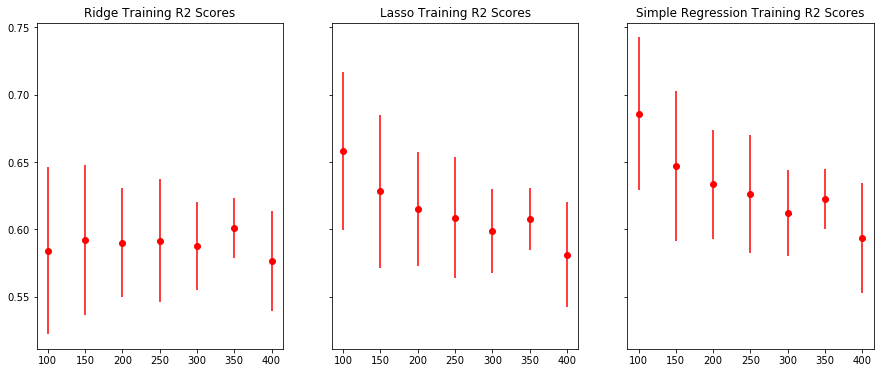

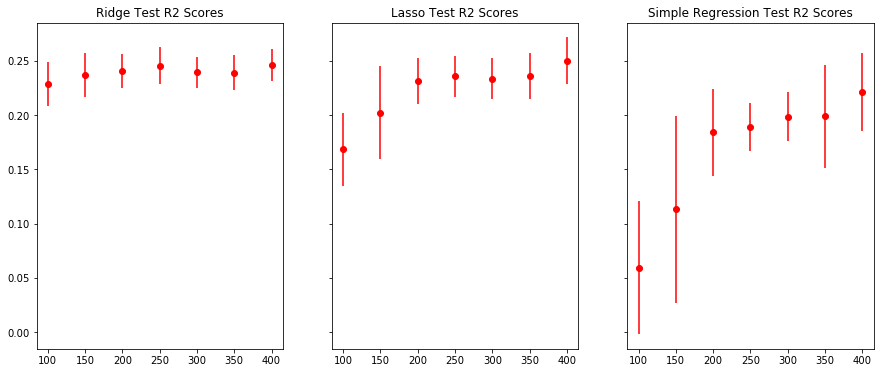

In [90]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,6))


ax1.errorbar(df.sample_size.values, df.avg_training_ridge.values, c='red', yerr=df.SD_train_ridge.values, fmt='o')
ax1.set_title("Ridge Training R2 Scores")
ax1.set_ylabel="R2"
ax1.set_xlabel="sample size"

ax2.errorbar(df.sample_size.values, df.avg_training_lasso.values, c='red', yerr=df.SD_train_lasso.values, fmt='o')
ax2.set_title("Lasso Training R2 Scores")

ax3.errorbar(df.sample_size.values, df.avg_training_simpl.values, c='red', yerr=df.SD_train_simpl.values, fmt='o')
ax3.set_title("Simple Regression Training R2 Scores")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,6) )
ax1.errorbar(df.sample_size.values, df.avg_test_ridge.values, c='red', yerr=df.SD_test_ridge.values, fmt='o')
ax1.set_title("Ridge Test R2 Scores")

ax2.errorbar(df.sample_size.values, df.avg_test_lasso.values, c='red', yerr=df.SD_test_lasso.values, fmt='o')
ax2.set_title("Lasso Test R2 Scores")

ax3.errorbar(df.sample_size.values, df.avg_test_simpl.values, c='red', yerr=df.SD_test_simpl.values, fmt='o')
ax3.set_title("Simple Regression Test R2 Scores")

plt.show()

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

*Analysis*

There is an inverse relationship between test and training R2 for the 3 regressions. The simple regression has the highest training R2. This is to be expected, as there is no penalty. However, the test R2 suffers as a result of this overfitting. The Lasso and Ridge, while having lower training R2, have much better performance on the testing data as a result of the regularization penalty. Ridge performs the best of the three for predicting on the test set for all sample sizes, Lasso only performs as well as Ridge when the sample size is large. As far as the confidence intervals, they tighten as the sample size increases. This is to be expected. Given a small sample size, we would use Ridge regression with an alpha value of 10.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

*Analysis*

Our R2 on this part, compared to homework three is significantly better. Of our 40 predictors, 9 seem statistically significant based upon p values obtained from OLS. A few others are very close, perhaps warranting inclusion. Our model still has high dimensionality and high collinaearity, however.

In [91]:
train_data['temp^2'] = train_data['temp']**2
test_data['temp^2'] = test_data['temp']**2
train_data['temp^3'] = train_data['temp']**3
test_data['temp^3'] = test_data['temp']**3
train_data['temp^4'] = train_data['temp']**4
test_data['temp^4'] = test_data['temp']**4

train_data['atemp^2'] = (train_data['atemp'])**2
test_data['atemp^2'] = (test_data['atemp'])**2
train_data['atemp^3'] = (train_data['atemp'])**3
test_data['atemp^3'] = (test_data['atemp'])**3
train_data['atemp^4'] = (train_data['atemp'])**4
test_data['atemp^4'] = (test_data['atemp'])**4

train_data['humidity^2'] = (train_data['humidity'])**2
test_data['humidity^2'] = (test_data['humidity'])**2
train_data['humidity^3'] = (train_data['humidity'])**3
test_data['humidity^3'] = (test_data['humidity'])**3
train_data['humidity^4'] = (train_data['humidity'])**4
test_data['humidity^4'] = (test_data['humidity'])**4

train_data['windspeed^2'] = (train_data['windspeed'])**2
test_data['windspeed^2'] = (test_data['windspeed'])**2
train_data['windspeed^3'] = (train_data['windspeed'])**3
test_data['windspeed^3'] = (test_data['windspeed'])**3
train_data['windspeed^4'] = (train_data['windspeed'])**4
test_data['windspeed^4'] = (test_data['windspeed'])**4


In [92]:
# create an array of values for our regression
y_train = train_data['rentals'].values
X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4']].values

y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4']].values

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)


train_data.head(5)


(331, 40) (331, 1) (400, 40) (400, 1)


,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3,temp^2,temp^3,temp^4,atemp^2,atemp^3,atemp^4,humidity^2,humidity^3,humidity^4,windspeed^2,windspeed^3,windspeed^4
0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.389124,0.242735,0.151418,0.422637,0.274759,0.178622,0.847622,0.780375,0.718464,0.862591,-0.801139,0.744064
1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.032512,-0.005862,0.001057,0.002998,-0.000164,0.000009,0.485603,0.338393,0.235810,0.045583,-0.009732,0.002078
2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.643989,0.516794,0.414722,0.725044,0.617372,0.525689,0.201047,-0.090146,0.040420,0.646297,0.519575,0.417699
3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.311895,-3.515217,5.344859,2.449794,-3.834373,6.001490,0.110299,-0.036632,0.012166,0.072414,-0.019487,0.005244
4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0.285640,0.152661,0.081590,0.121119,0.042152,0.014670,3.903744,7.712976,15.239217,1.437666,-1.723801,2.066885


In [93]:
# fit model with the additional interaction terms, compute metrics
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print('The equation of the regression plane is: {} + {} * x'.format(lm.intercept_, lm.coef_))

train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))



The equation of the regression plane is: [ 5035.27125887] + [[ -189.7675006    351.27394405   771.48662326   897.2756023   -668.91446319
   -446.50850455   766.43070371  1578.75436674  1523.2288234   -325.06857397
   -304.84911267  -418.02446177 -1037.20424547 -1456.18565573
  -1416.98816779 -1715.93889094 -1073.40080145  -925.87103867
   -825.53284158  -555.66756465   -93.32647706  -133.42791146   147.7312741
     30.59243395   209.93712392   471.0834343     59.01188326
  -1043.99967412 -1811.01797233     8.60775572   -45.191024    1175.50049569
   -303.93578541   -20.76855912   -53.67085686   -16.05763165   -24.8367323
    -34.16534669    44.8338792    -20.17694855]] * x
The train MSE is 1233551.6134555764, the test MSE is 3157061.4234926915
The train R^2 is 0.6696562402214016, the test R^2 is 0.27723843508615387


In [94]:
# statsmodel regression to easily obtain metrics

# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
# build the OLS model from the training data
smm = sm.OLS(y_train, X)

#save regression info in results_sm
results_sm = smm.fit()

print(results_sm.summary())
print('Parameters: ', results_sm.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     15.13
Date:                Thu, 12 Oct 2017   Prob (F-statistic):           7.98e-50
Time:                        02:47:40   Log-Likelihood:                -2790.9
No. Observations:                 331   AIC:                             5662.
Df Residuals:                     291   BIC:                             5814.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5035.2713    460.417     10.936      0.0

In [95]:
train_data['month12_temp'] = train_data['month_12'] * train_data['temp']

train_data['workday_weather'] = np.where((train_data['workingday'] ==1) & (train_data['weather_2'] ==0) & 
                                (train_data['weather_3']==0), 1, 0)

test_data['month12_temp'] = test_data['month_12'] * test_data['temp']

test_data['workday_weather'] = np.where((test_data['workingday'] ==1) & (test_data['weather_2'] ==0) & 
                                (test_data['weather_3']==0), 1, 0)



In [96]:
pd.set_option('display.max_columns', None)
train_data.head()

,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3,temp^2,temp^3,temp^4,atemp^2,atemp^3,atemp^4,humidity^2,humidity^3,humidity^4,windspeed^2,windspeed^3,windspeed^4,month12_temp,workday_weather
0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.389124,0.242735,0.151418,0.422637,0.274759,0.178622,0.847622,0.780375,0.718464,0.862591,-0.801139,0.744064,0.000000,0
1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.032512,-0.005862,0.001057,0.002998,-0.000164,0.000009,0.485603,0.338393,0.235810,0.045583,-0.009732,0.002078,-0.180310,1
2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.643989,0.516794,0.414722,0.725044,0.617372,0.525689,0.201047,-0.090146,0.040420,0.646297,0.519575,0.417699,0.000000,1
3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.311895,-3.515217,5.344859,2.449794,-3.834373,6.001490,0.110299,-0.036632,0.012166,0.072414,-0.019487,0.005244,-1.520492,0
4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0.285640,0.152661,0.081590,0.121119,0.042152,0.014670,3.903744,7.712976,15.239217,1.437666,-1.723801,2.066885,0.000000,0


In [97]:
# create an array of values for our regression
y_train = train_data['rentals'].values
X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4', 'workday_weather', 'month12_temp']].values

y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4', 'workday_weather', 'month12_temp']].values

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

train_data.head(5)


(331, 42) (331, 1) (400, 42) (400, 1)


,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3,temp^2,temp^3,temp^4,atemp^2,atemp^3,atemp^4,humidity^2,humidity^3,humidity^4,windspeed^2,windspeed^3,windspeed^4,month12_temp,workday_weather
0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.389124,0.242735,0.151418,0.422637,0.274759,0.178622,0.847622,0.780375,0.718464,0.862591,-0.801139,0.744064,0.000000,0
1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.032512,-0.005862,0.001057,0.002998,-0.000164,0.000009,0.485603,0.338393,0.235810,0.045583,-0.009732,0.002078,-0.180310,1
2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.643989,0.516794,0.414722,0.725044,0.617372,0.525689,0.201047,-0.090146,0.040420,0.646297,0.519575,0.417699,0.000000,1
3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.311895,-3.515217,5.344859,2.449794,-3.834373,6.001490,0.110299,-0.036632,0.012166,0.072414,-0.019487,0.005244,-1.520492,0
4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0.285640,0.152661,0.081590,0.121119,0.042152,0.014670,3.903744,7.712976,15.239217,1.437666,-1.723801,2.066885,0.000000,0


In [98]:
# fit model with the additional interaction terms, compute metrics
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print('The equation of the regression plane is: {} + {} * x'.format(lm.intercept_, lm.coef_))

train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The equation of the regression plane is: [ 5002.87217487] + [[ -1.74548786e+02   2.51998375e+02   7.95078743e+02   8.81715282e+02
   -6.76351913e+02  -4.47079697e+02   7.63637875e+02   1.56427958e+03
    1.49316259e+03  -3.25739496e+02  -3.11735875e+02  -4.29582296e+02
   -1.02485943e+03  -1.46665414e+03  -1.42767388e+03  -1.72063755e+03
   -1.05590929e+03  -8.82233606e+02  -7.73613283e+02  -4.80922153e+02
   -1.07457193e+02  -1.48195150e+02   1.29095641e+02   1.21349048e+01
    1.91871387e+02   4.62448641e+02   1.81873517e+02  -9.23040593e+02
   -1.80185812e+03   1.66279577e+00  -4.47557316e+01   1.17067291e+03
   -2.98989072e+02  -2.10470354e+01  -5.65186328e+01  -1.50310861e+01
   -2.39876686e+01  -3.78573222e+01   4.45758104e+01  -1.93589160e+01
    1.65026491e+02   4.44106026e+01]] * x
The train MSE is 1232388.953387242, the test MSE is 3131990.9875292666
The train R^2 is 0.6699675993036875, the test R^2 is 0.2829779330240658


## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [ ]:
# The additional dimensions are interactions between the one-hot variables. While this analysis can capture some
# complex relationships, we only have 331 data items to begin with, and as the combinations of different parameters
# grows, you can quickly run out of data! When the number of factors exceeds the number of data items, the regression is
# unspecified. The purpose of PCA is to reduce the number of factors into groups of the most influential ones.

# The first three PCA components accounted for 46%, 21% and 19% of the variation in our data. 

# We decided to stick with the predictors without the interaction terms, because we did not find them to be statistically
# significant.


In [113]:
#create polynomial features matrix
polynomial_features = PolynomialFeatures(degree=1, interaction_only=True, include_bias=True)
poly = polynomial_features.fit_transform(X_train)


#Using too many features can create an overfitting problem, particularly if they are of high degree - the training
#process will fit to the noise! Here, the degree of the factors isn't high (limited to 1), but with enough factors,
#you could wind up with more factors than you have data items, in which case the model is not specified.


pca1 = PCA(n_components=1)
pca1.fit(X_train)
X_train_pca1 = pca1.transform(X_train)
X_test_pca1 = pca1.transform(X_test)
print('Explained variance ratio:', pca1.explained_variance_ratio_)

pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_train_pca2 = pca2.transform(X_train)
X_test_pca2 = pca2.transform(X_test)
print('Explained variance ratio:', pca2.explained_variance_ratio_)

pca3 = PCA(n_components=3)
pca3.fit(X_train)
X_train_pca3 = pca3.transform(X_train)
X_test_pca3 = pca3.transform(X_test)
print('Explained variance ratio:', pca3.explained_variance_ratio_)



Explained variance ratio: [ 0.46123346]
[[ -4.56350851e-04  -1.30637936e-03  -2.43585426e-02  -2.62500820e-02
   -1.88305024e-02   5.68188099e-02  -1.97999683e-03  -5.74257761e-03
   -3.80104140e-03   6.12190924e-03   3.60177162e-03   9.51634682e-04
   -2.64119912e-03  -1.34425553e-03  -2.74732289e-03  -1.58700340e-03
   -2.14616037e-03  -1.70033278e-03  -9.03383335e-04  -2.42813544e-04
    5.58731456e-04   1.48630748e-03  -1.83413829e-03  -2.63235240e-03
    6.58721549e-04   1.48868776e-03   7.67228134e-04   5.60494234e-04
    1.16305876e-02  -6.04297300e-02   7.30587192e-02   1.87160516e-02
   -8.02179436e-02   1.29792502e-01   3.22434422e-02  -5.44238937e-02
    1.12441696e-01   1.27833825e-01   3.38050800e-01   9.02754649e-01]]
Explained variance ratio: [ 0.46123346  0.21350874]
Explained variance ratio: [ 0.46123346  0.21350874  0.19390969]


In [100]:
regression_model_pca1 = LinearRegression(fit_intercept=True)
regression_model_pca1.fit(X_train_pca1, y_train)
y_pred_1 = regression_model_pca1.predict(X_test_pca1)
score_1 = r2_score(y_test, y_pred_1)

print('PCA w 1 component Test R^2: {}'.format(score_1))

regression_model_pca2 = LinearRegression(fit_intercept=True)
regression_model_pca2.fit(X_train_pca2, y_train)

print('PCA w 2 component Test R^2: {}'.format(regression_model_pca2.score(X_test_pca2, y_test)))

regression_model_pca3 = LinearRegression(fit_intercept=True)
regression_model_pca3.fit(X_train_pca3, y_train)

print('PCA w 3 component Test R^2: {}'.format(regression_model_pca3.score(X_test_pca3, y_test)))

PCA w 1 component Test R^2: -0.058160712318159336
PCA w 2 component Test R^2: 0.012089582480906969
PCA w 3 component Test R^2: -0.020903459867501306


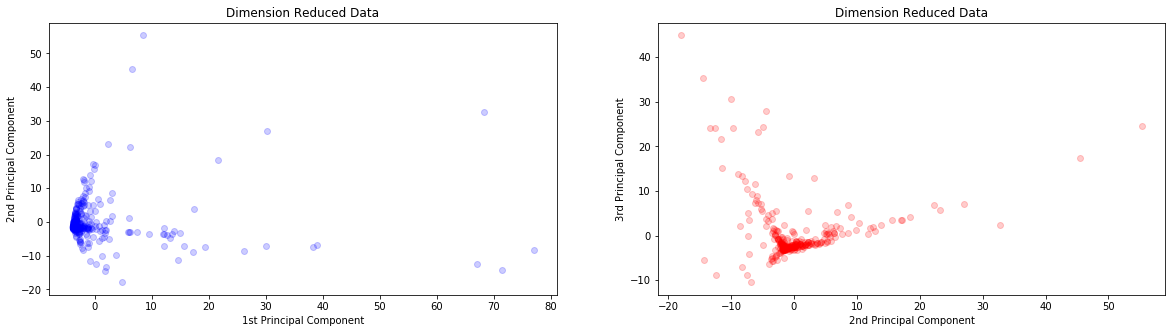

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_train_pca3[:, 1], X_train_pca3[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')


plt.show()


## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [102]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    where_are_NaNs = np.isnan(np.log(y_pred+1))
    y_pred[where_are_NaNs] = 0
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    print("RMSLE is ", rmsle_)
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [109]:
print("Train:")
RMSLE = rmsle(y_train, lm.predict(X_train))
print("Test:")
RMSLE = rmsle(y_test, lm.predict(X_test))

# Our best guess is that we would use RMSLE to estimate a kind of lambda factor. The idea is that it is a logarithmic measure and
# can measure actual versus predicted values according to this relationship: log((pi+1)/(ai+1)), where pi is the
# predicted value and ai is the actual. It can be used to penalize under-estimates on a different basis than
# over-estimates, as might be the case when the suppliers of the bicycles being studied here are trying to decide how
# many bikes to stock - if people expect to face a stock-out because it is a busy day, you're not so worried about
# estimating demand, but if you underestimate demand on a lighter day, you could make a number of customers angry.
#
# It should be noted that the lambda we are suggesting above would a *multiplier* to *increase* estimated rentals
# givne a high RMSLE than the way we've used it elsewhere here, as a reducer. And it may be outside the regression
# equation entirely, but rather as a "post-processing" multiplier where you estimate rentals given parameters provided
# by the regression, AND THEN apply the multiplier suggested by the RMSLE.




Train:
RMSLE is  0.721457659701
Test:
RMSLE is  0.857618314536


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


your answers here

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [104]:
# your code here


for x in range(0, 331):
    if (train_data.get_value(x, 'month_2') == 1 or train_data.get_value(x, 'month_3') == 1):
        train_data.set_value('season_2', x, 0)
        train_data.set_value('season_3', x, 0)
        train_data.set_value('season_4', x, 0)
    elif (train_data.get_value(x, 'month_4') == 1 or train_data.get_value(x, 'month_5') == 1 or train_data.get_value(x, 'month_6') == 1):
        train_data.set_value('season_2', x, 1)
        train_data.set_value('season_3', x, 0)
        train_data.set_value('season_4', x, 0)
    elif (train_data.get_value(x, 'month_7') == 1 or train_data.get_value(x, 'month_8') == 1 or train_data.get_value(x, 'month_9') == 1):
        train_data.set_value('season_2', x, 0)
        train_data.set_value('season_3', x, 1)
        train_data.set_value('season_4', x, 0)
    elif (train_data.get_value(x, 'month_10') == 1 or train_data.get_value(x, 'month_11') == 1 or train_data.get_value(x, 'month_12') == 1):
        train_data.set_value('season_2', x, 0)
        train_data.set_value('season_3', x, 0)
        train_data.set_value('season_4', x, 1)
        



y_train = train_data['rentals'].values
y_train = y_train[0:-3]
y_train = y_train.reshape(len(y_train), 1)

X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4']].values
X_train = X_train[0:-3]
y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3', 'temp^2', 'temp^3', 'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'humidity^2', 'humidity^3', 
                 'humidity^4', 'windspeed^2', 'windspeed^3', 'windspeed^4']].values

y_test = y_test.reshape(len(y_test), 1)

print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print('The equation of the regression plane is: {} + {} * x'.format(lm.intercept_, lm.coef_))

train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

(331, 40) (331, 1) (400, 40) (400, 1)
The equation of the regression plane is: [ 5035.27125887] + [[ -189.7675006    351.27394405   771.48662326   897.2756023   -668.91446319
   -446.50850455   766.43070371  1578.75436674  1523.2288234   -325.06857397
   -304.84911267  -418.02446177 -1037.20424547 -1456.18565573
  -1416.98816779 -1715.93889094 -1073.40080145  -925.87103867
   -825.53284158  -555.66756465   -93.32647706  -133.42791146   147.7312741
     30.59243395   209.93712392   471.0834343     59.01188326
  -1043.99967412 -1811.01797233     8.60775572   -45.191024    1175.50049569
   -303.93578541   -20.76855912   -53.67085686   -16.05763165   -24.8367323
    -34.16534669    44.8338792    -20.17694855]] * x
The train MSE is 1233551.6134555764, the test MSE is 3157061.4234926915
The train R^2 is 0.6696562402214016, the test R^2 is 0.27723843508615387


In [105]:
''' 

Analysis

1. I would start off with checking the season and month figures for inconsistencies. 
2. I would also check for consistencies between the working day binary parameter and the binary day flags.
3. I would check for sanity in the deltas between atemp and temp

We visually inspected all three, and found a number of errors in 1, i.e., a season number would be ascribed to a
tuple with a month that didn't match. We were only able to find one error for #2, and could not find any errors for #3.
(We visually inspected deltas between temp and atemp and didn't find anything noteworthy.)

Our solution: assign season automatically depending on month for the entire training data set.

It turned out that our r-squared was actually REDUCED from 0.282 to 0.277! Cleaning the data did not impact our
results in any meaningful way. However, it may be that there is some more creative way to clean the data that we
simply did not think of, so we leave the door open to the possibility of obtaining more meaningful results.

'''


" \n\nAnalysis\n\n1. I would start off with checking the season and month figures for inconsistencies. \n2. I would also check for consistencies between the working day binary parameter and the binary day flags.\n3. I would check for sanity in the deltas between atemp and temp\n\nWe visually inspected all three, and found a number of errors in 1, i.e., a season number would be ascribed to a\ntuple with a month that didn't match. We were only able to find one error for #2, and could not find any errors for #3.\n(We visually inspected deltas between temp and atemp and didn't find anything noteworthy.)\n\nOur solution: assign season automatically depending on month for the entire training data set.\n\nIt turned out that our r-squared was actually REDUCED \n\n"

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [106]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [107]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

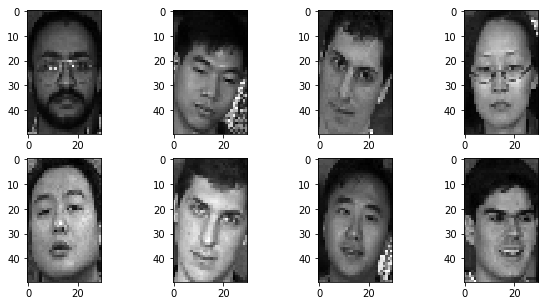

In [108]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()